# 【第２回目　課題２】PyTorchを使った深層学習 (2): 畳み込み編
    
課題１に引き続いてPytorchのSequential modelを用いて，前回の課題２のフィルタ学習を行ってみます．
エッジ検出のフィルタを3層の畳み込みネットワークで学習してみます．

入出力は画像ですが，基本的に出力回帰問題ですので，課題１と同じで，最小２乗誤差を用いて学習します．

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
# 必要があれば，GPU IDを指定します．
# IEDは 8GPUなので必ず指定してください．
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"

次に画像の読み込みに必要なPIL, 表示に必要なmatplotlibなどのモジュールを読み込みます．

In [2]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

画像を読み込んで，エッジ画像を生成して，学習データを作ります．Canny法でエッジ抽出します．
use_edge=Falseとすれば，目標画像を濃淡画像にするので，濃淡化フィルタの学習になります．

なお，PyTorchでは，テンソルは Batch, Channel, Height, Width の順番に表現しますので，
読み込んだ画像を
img=img.transpose(2,0,1) で HWC から CHW へ変換して，さらに batchの軸を
gt=gt[np.newaxis, ...]
で追加します．

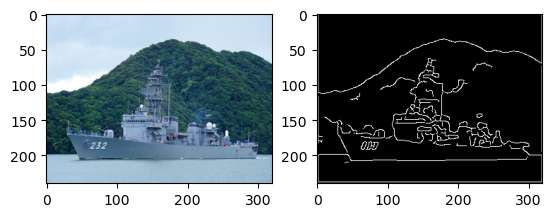

In [3]:
#img_org = Image.open('Kobo2022_pytorch-master/image/DE_SENDAI.jpeg').resize((320,240))
#img = np.array(img_org, dtype=np.uint8) #np.unit8 8ビットの符号なし整数
#grey = np.array(img_org.convert('L'), dtype=np.uint8) #GreyScale画像への変換 
#edge = feature.canny(grey,sigma=2)  # Canny でエッジ抽出

img_org = Image.open('Kobo2022_pytorch-master/DE_SENDAI.jpeg').resize((320,240))
img = np.array(img_org, dtype=np.uint8) #np.unit8 8ビットの符号なし整数
grey = np.array(img_org.convert('L'), dtype=np.uint8) #GreyScale画像への変換 
edge = feature.canny(grey,sigma=2)  # Canny でエッジ抽出

##edge = filters.sobel(grey) # Sobel でエッジ抽出
##print(edge)
edge = edge * 255
##print(edge)

# エッジ検出フィルタ，グレースケール化フィルタの切り替え
use_edge=True  # Falseだとグレースケール化フィルタの学習
if use_edge:
    gt=edge
else:
    gt=grey

plt.subplot(121) #サブプロットの記法https://www.yutaka-note.com/entry/2020/01/02/232925
plt.imshow(img)
plt.subplot(122)
plt.imshow(gt,cmap="gray")
img=img.transpose(2,0,1) # numpy軸変換　HWC から CHW へ変換　https://qiita.com/jun40vn/items/3b4d53f40e160b777a5a
gt=gt[np.newaxis, ...]

#print(img.shape,gt.shape)

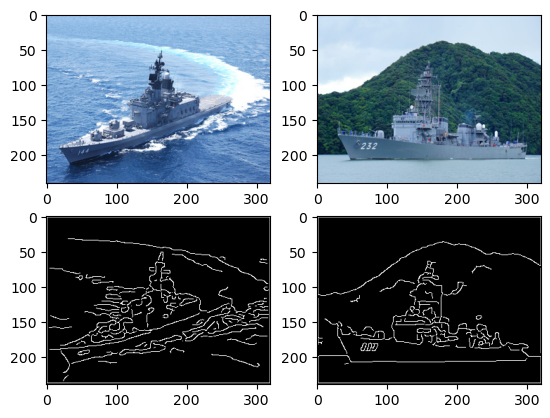

In [4]:
img_org2 = []
img2 = []
grey2 = []
edge2 = []
gt2 = []
for i in range(1,3):
    img_org2.append(Image.open('Kobo2022_pytorch-master/image/DD' + str(i) + '.jpeg').resize((320,240)))

for i, DDx in enumerate(img_org2):
    img2.append(np.array(DDx, dtype=np.uint8)) 
    grey2.append(np.array(DDx.convert('L'), dtype=np.uint8)) 
    edge2.append(feature.canny(grey2[i],sigma=2)) 
    edge2[i] = edge2[i] * 255
    use_edge = True  # Falseだとグレースケール化フィルタの学習
    if use_edge:
        gt2.append(edge2[i])
    else:
        gt2.append(grey2[i])
    plt.subplot(2,2,1+i)
    plt.imshow(img_org2[i])
    plt.subplot(2,2,3+i)
    plt.imshow(edge2[i], cmap='gray')
    img2[i] = img2[i].transpose(2,0,1) # numpy軸変換　HWC から CHW へ変換　https://qiita.com/jun40vn/items/3b4d53f40e160b777a5a
    gt2[i] = gt2[i][np.newaxis, ...]

### 読み込んだ画像と変換した画像を，numpy形式に変換します．
(c,h,w) c:チャネル, h:高さ, w:幅　のサイズの3次元配列にします．
PyTorch の標準の形式は，(c,h,w) です.

ここでは画像は320x240で，入力はカラーなので，
input: (3,240,320)
output: (1,240,320)
の大きさです．

In [5]:
# 画素値が [-1,1) の範囲の値になるように変換
# Keras は (h,w,c)が標準ですので，前回の
#input  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0 の transposeが不要になります．
input  = (np.asarray(img, dtype=np.float32)-127.5)/127.5 #np.asarray 元のNumpy配列と同期され続けるコピー
output = (np.asarray(gt, dtype=np.float32)-127.5)/127.5

# Keras では，convolution へ与えるデータは最初にbatchの次元を追加して４次元テンソルで表現します．
# 画像１枚での学習なので，batch は 1 です．
# さらに，torch形式のtensorへ変換します． .newaxisNumPy配列ndarrayに新たな次元を追加する
input = torch.from_numpy(input[np.newaxis, ...])     # (3, 240,320) -> (1,3, 240,320)
output = torch.from_numpy(output[np.newaxis, ...])   # (1, 240,320) -> (1,1, 240,320)

input.max(),input.min(),output.shape,input.shape

(tensor(1.),
 tensor(-1.),
 torch.Size([1, 1, 240, 320]),
 torch.Size([1, 3, 240, 320]))

In [6]:
input2  = (np.asarray(img2, dtype=np.float32)-127.5)/127.5 #np.asarray 元のNumpy配列と同期され続けるコピー
output2 = (np.asarray(gt2, dtype=np.float32)-127.5)/127.5
input2 = torch.from_numpy(input2[np.newaxis, ...])     # (3, 240,320) -> (1,3, 240,320)
output2 = torch.from_numpy(output2[np.newaxis, ...])   # (1, 240,320) -> (1,1, 240,320)

input2.max(),input2.min(),output2.shape,input2.shape
#print(input2)

(tensor(1.),
 tensor(-1.),
 torch.Size([1, 2, 1, 240, 320]),
 torch.Size([1, 2, 3, 240, 320]))

In [7]:
#torchを使うと簡単に正規化できる

from torchvision import transforms as transforms
# https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html

preprocess = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),# -1 ~ 1
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )#  output[channel] = (input[channel] - mean[channel]) / std[channel]
    ]
)
#イメージフォルダを使う
#https://reafnex.net/ai/pytorch-use-imagefolder/

img_org = Image.open('Kobo2022_pytorch-master/DE_SENDAI.jpeg').resize((320,240))
print('preprocessed_shape',preprocess(img_org).shape)
input = preprocess(img_org).unsqueeze(0)
print('input_shape',input.shape)

preprocessed_shape torch.Size([3, 240, 320])
input_shape torch.Size([1, 3, 240, 320])


mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]  
ImageNet という画像分類データセットの RGB の平均と標準偏差。  
torchvision の事前学習済みモデルを利用するならこれを使う必要がありますが、自作のモデルでゼロから学習するなら、自分のデータセットの平均と分散を計算しておいてそれを使うほうがいい。

In [8]:
# 学習途中のlossなどのグラフ表示を行う ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph:
    def __init__(self,model,max_epoch,test_img):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 1])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.model=model
        self.max_epoch=max_epoch
        self.test_img=test_img
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, out):
        #batchを1以上にするときはoutの形に気を付ける
        out = out[0]
        self.n_epoch.append(epoch)
        self.losses.append(loss)
        self.loss=loss
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"r") 
        self.out=(out.squeeze()+1.0)*127.5  # 表示するときは，[0.255]に戻します．
        #print out.shape, self.out.shape
        self.fig2.imshow(self.out.detach().numpy(),cmap="gray",vmin=0,vmax=255)
        display.display(self.fig)
        if epoch<self.max_epoch-1:
            self.fig2.cla()

    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss:",self.loss)
        print('Time: ',time.time()-self.start)

畳み込み層を3つ用意します．
3x3x20 -> 3x3x20 -> 3x3x1 です．
1,2層目はReLU付きです．

<a href="https://pytorch.org/docs/stable/nn.html#conv2d">Conv2d</a>を利用します．PyTorchでは，Conv2dのdは小文字ですので，注意してください．

特徴マップのサイズを変化させたくない場合は，3x3のConvの場合，padding=1とします．

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)  
  
dilation: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md  
kernel_size, padding, stride: https://exture-ri.com/2021/01/11/pytorch-cnn/  
group:https://cvml-expertguide.net/terms/dl/layers/convolution/grouped-convolution/  



In [9]:
# c1=Conv(3,3,3,10,pad=1)
#c2=Conv(10,3,3,10,pad=1)
#c3=Conv(10,3,3,1,pad=1,relu=0)

model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)

In [10]:
print(model)

Sequential(
  (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(20, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [11]:
#print(torch.__version__)

#### 上のモデルをnn.Moduleで書けるようにしておこう


In [12]:
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
    def __init__():
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 20, 3, padding=1)
        self.conv2d_2 = nn.Conv2d(20, 20, 3, padding=1)
        self.conv2d_3 = nn.Conv2d(20, 1, 3, padding=1)
    def forward(self, x):
        x = self.Conv2d_1(x)
        x = F.relu(x)
        x = self.Conv2d_2(x)
        x = F.relu(x)
        x = self.Conv2d_3(x)
        return x

class Model_Sequential(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Conv2d_1(3, 20, 3, padding=1),
            nn.Relu(),
            nn.Conv2d_2(20, 20, 3, padding=1),
            nn.Relu(),
            nn.Conv2d_3(20, 1, 3, padding=1)
        )
    def forward(self, x):
        x = self.sequential_mode(x)
        rerturn(x)

CPUからGPUにモデルと学習データを転送します．
これを忘れるとCPUで計算するので，時間かかってしまします．

In [13]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device('mps') #M1 GPU, pytorch beta version(nightly)
model = model.to(device)
input = input.to(device)
output = output.to(device)

In [14]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device('mps') #M1 GPU, pytorch beta version(nightly)
model2 = model.to(device)
input2 = input2.to(device)
output2 = output2.to(device)

学習ループです．
学習率lr = 0.01
エポック数200とします．
3課題１と同様に，MSE loss(二乗誤差), SGDを利用します．momentum=0.9とします．

In [15]:
num_epoch=500
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
#optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

loss: 0.11285547912120819
Time:  12.87225604057312


loss: 0.11047361046075821
Time:  18.36365580558777


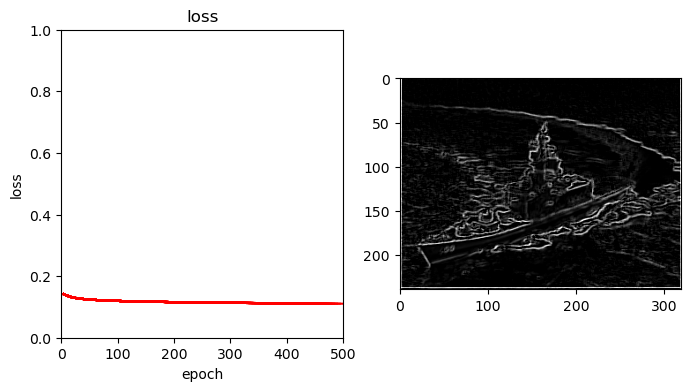

In [16]:
num_epoch=500
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
#optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input2[0])
show_graph.on_train_begin();

model2.train()

for t in range(num_epoch):
    out = model2(input2[0])

    # Compute and print loss.
    loss = loss_fn(out, output2[0])
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

学習したモデルで画像を変換（エッジ抽出）してみます．

torch.Size([1, 3, 240, 320]) (1, 1, 240, 320)
2.567201 -1.8003485
1.0 -1.0


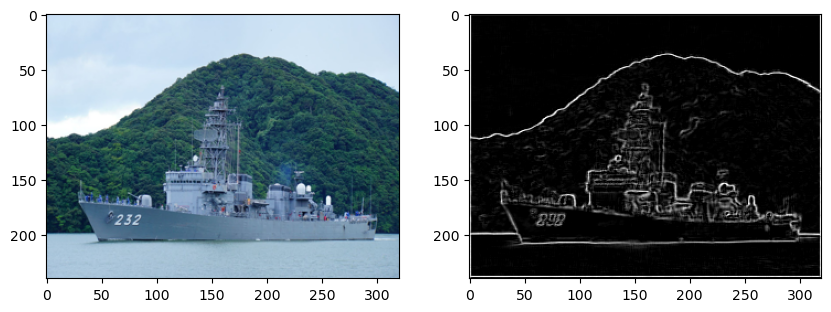

In [17]:
img=np.array(Image.open('Kobo2022_pytorch-master/DE_SENDAI.jpeg').resize((320,240)), dtype=np.float32)
#img=np.array(Image.open('Kobo2022_pytorch-master/image/uec_mark.jpeg').resize((320,240)), dtype=np.float32)

img2=img[np.newaxis,...].transpose(0,3,1,2)
img2=torch.from_numpy(img2/127.5-1.0)
model.eval() # batch normalization, dropoutがある時は，trainとevalの時で挙動が異なるので，モードを切り替えます．

with torch.no_grad():
    out=model(img2.to(device)).cpu().detach().numpy()
print(img2.shape,out.shape)
print(np.max(out),np.min(out))
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
print(np.max(out),np.min(out))
out=(out+1.0)*127.5                 # 表示するときは，[0..255]に戻します．
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img/255)  # 値が floatの場合は 値域が [0,1] になるようにします．
plt.subplot(122)
plt.imshow(np.squeeze(out),cmap="gray",vmin=0,vmax=255)
plt.show()

### 課題2
サンプル画像を各自，自分で用意した画像に入れ替えて，以下の小問の(1)-(3)を解答すること．

1. OptimizerをRMSprop, Adamに変更して，モーメンタムSDGとの違いを観察せよ．
1. (1)で最もlossが小さくなったoptimizerを利用して，Batch Normalization Layer を入れた場合と入れない場合で，結果を比較せよ．
    - https://data-analytics.fun/2021/09/11/understanding-batch-normalization/
1. 複数の画像に対応させてみよ．学習画像を2枚, 3枚とするとどうなるか？

(1)OptimizerをRMSprop, Adamに変更して，モーメンタムSDGとの違いを観察した．学習モデルで変換した画像は、Adam以外のOptimiserがエッジ処理と近い画像だった.Adamはグレースケールでのエッジ抽出のように見える.また、いずれのoptimiserの場合でも本来のエッジ処理だとつぶれてしまった細かい部分もエッジ抽出できている。

loss は、それぞれのoptimiserでSGD 0.15, RMSprop 0.18, Adam 0.13であった。
SGD
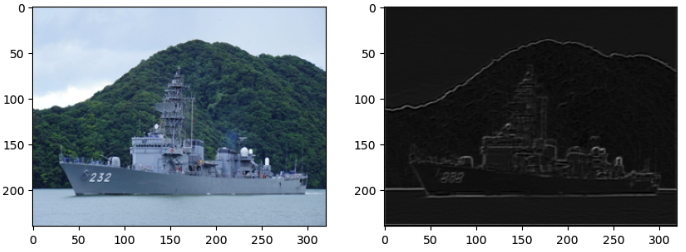
RMSprop
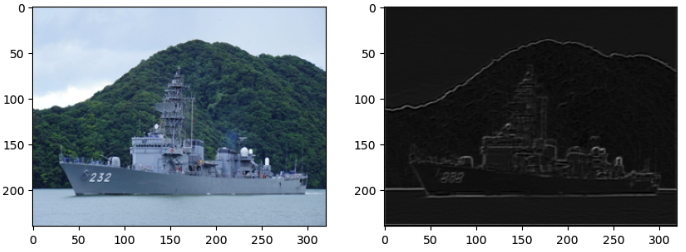
Adam
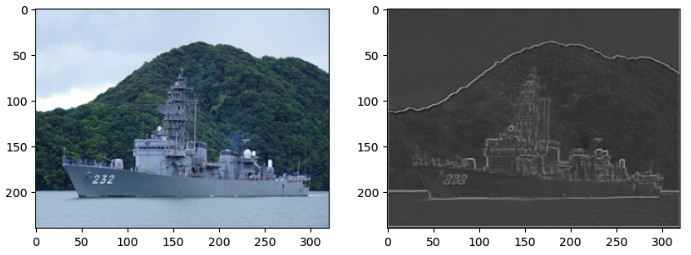

(2) optimizer Adamを利用して，Batch Normalization Layer を入れると入れない場合からloss 0.13から0.11に改善した。変換された画像はよりエッジがはっきりとしている。さらに細かい部分、具体的には艦首で作業をしている甲板員やマストの対空レーダーのエッジを抽出できている。
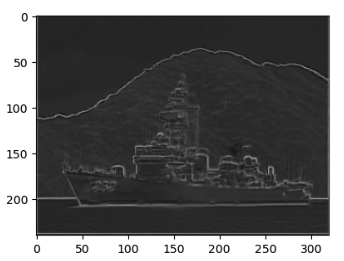


(3) 画像2枚を学習させて結果を観察する。<br>
画像をnumpy配列として読み込み、1バッチ2枚として計算した。
結果は1枚のときのloss 0.112に比べて2枚のときはloss 0.110となりlossが減少した。これはよりサンプル数を増やせば学習モデルの性能が上がることを示している。
